In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar

from bs_fdbck.util.imports import import_fields_xr_echam

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud,rn_dic_noresm_cloud

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

import pandas as pd

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [3]:
from timeit import default_timer as timer



from dask.diagnostics import ProgressBar

from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [4]:

select_station = 'SMR'

In [5]:
xr.set_options(keep_attrs=True) 

In [6]:
calc_seasons = ['ALL_year']

In [7]:
tau_lims = [5,50]
r_eff_lim = 1
cloud_top_temp_above = -15 
cld_water_path_above = 50
#include_months = [7,8]

In [8]:
from bs_fdbck.constants import path_measurement_data
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'



In [9]:
lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

temperature = 273.15  # K




from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'
sel_years_from_files = ['2012','2014','2015','2018']

## Daytime values


Set the daytime to be from 10 to 17 each day

In [10]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [11]:
models = ['ECHAM-SALSA','NorESM','EC-Earth']
mod2cases = {'ECHAM-SALSA':['SALSA_BSOA_feedback'],
             'NorESM':['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth':['ECE3_output_Sara'],
            }
di_mod2cases = mod2cases.copy()

In [12]:
dic_df_station=dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_EC-Earth_ECE3_output_Sara.csv


<AxesSubplot:xlabel='time'>

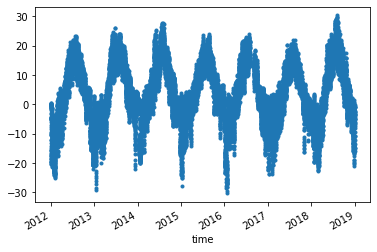

In [13]:
dic_df_station[mod][ca]['T_C'].plot(marker='.')

## EC-Earth

### Names etc

In [14]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

### Input path:

In [15]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [16]:

cases_ec_earth = [case_name_ec_earth]

### Station variables  and others

### Define some strings for files

In [17]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'22.0-30.0_60.0-66.0'

### Filenames: 

In [18]:
fn_intermediate_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [19]:
fn_final_ec_earth_csv_stem

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0')

### Open data

In [20]:
which='IFS'

In [21]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'


In [22]:
fn_t.exists()

True

In [73]:
fl_open = []
#ds_list =[]
dic_ds =dict()

for which in ['IFS','IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')
        

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0.nc
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_T_2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0.nc


### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [74]:
import numpy as np

In [75]:
dic_df_station[model_name_ec_earth][case_name_ec_earth].head()

,station,time_orig,lev,CCN0.20,CCN1.00,M_BCACS,M_BCAII,M_BCAIS,M_BCCOS,M_DUACI,...,N150-500,N200-500,OA,POM,SOA,SOA2,T_C,is_JJA,is_JA,isSummer
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 02:00:00,SMR,2012-01-01 00:30:00.000000000,1.0,210.34949,328.70420,1.312838e-10,1.760822e-10,6.468536e-13,5.554017e-16,2.331612e-10,...,196.935490,101.754681,1.813057,1.737373,0.075684,0.075684,NaN,False,False,False
2012-01-01 03:00:00,SMR,2012-01-01 01:30:00.000000000,1.0,238.47906,370.82812,1.479828e-10,2.002312e-10,5.436276e-13,6.121766e-16,2.344173e-10,...,224.057987,116.241666,2.074929,1.999963,0.074966,0.074966,NaN,False,False,False
2012-01-01 04:00:00,SMR,2012-01-01 02:30:00.000000000,1.0,264.20963,408.75250,1.637148e-10,2.224790e-10,5.254167e-13,6.354531e-16,2.355444e-10,...,249.143457,129.551621,2.320950,2.244422,0.076527,0.076527,NaN,False,False,False
2012-01-01 05:00:00,SMR,2012-01-01 03:30:00.000000000,1.0,289.25140,443.42930,1.786072e-10,2.429668e-10,5.675244e-13,6.503565e-16,2.366023e-10,...,273.240513,142.554836,2.553694,2.472160,0.081534,0.081534,-14.315735,False,False,False
2012-01-01 06:00:00,SMR,2012-01-01 04:30:00.000000000,1.0,313.35242,475.29456,1.927297e-10,2.617789e-10,6.486790e-13,6.622721e-16,2.375622e-10,...,296.305901,155.159277,2.774989,2.684082,0.090908,0.090908,NaN,False,False,False


In [76]:
from bs_fdbck.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
    make_dummy_lev,
    
)

## Fix units, calc cloud properties etc.

In [77]:
if True:# not fn_intermediate_ec_earth.exists():
    

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds=rename_ifs_vars(_ds)
        
        _ds = fix_units_ec_earth(_ds)
        #_ds = calculate_incld_values_warmclouds(_ds)
        #_ds = extract_cloud_top(_ds)
        #_ds['lat'] = np.round(_ds['lat'], decimals=2)
        #_ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds=(
            _ds
            .assign(
                lat=lambda d:d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d:d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds
    

    ds = dic_ds['IFS']
    

renaming var130 to temp
renaming var131 to U
renaming var132 to V
renaming var136 to tcw
renaming var137 to tcwv
renaming var164 to ttc
renaming var176 to surf_net_srad
renaming var177 to surf_net_lrad
renaming var178 to toa_net_srad
renaming var179 to toa_net_lrad
renaming var20 to cdnc
renaming var208 to toa_net_srad_clear
renaming var21 to re_liq
renaming var210 to surf_net_srad_clear
renaming var211 to sur_net_lrad_clear
renaming var22 to liq_cloud_time
renaming var248 to cc
renaming var68 to toa_net_srad_clearclean
renaming var69 to toa_net_srad_clean
renaming var70 to surf_net_srad_clearclean
renaming var71 to surf_net_srad_clean
renaming var72 to toa_net_lrad_clearclean
renaming var73 to toa_net_lrad_clean
renaming var74 to surf_net_lrad_clearclean
renaming var75 to surf_net_lrad_clean
renaming var78 to tclw
renaming var79 to tciw
Converting tcw from kg/m2 to g/m2
Converting tcwv from kg/m2 to g/m2
Converting tclw from kg/m2 to g/m2
Converting tciw from kg/m2 to g/m2
renaming va

In [78]:
    ds = calculate_incld_values_warmclouds(ds)
    

calculating re_liq_incld
calculating cdnc_incld
calculating cl_time_liq_norm
Calulating cc_all
Calulating liq_frac_cwp
calculating cl_frac_where_cltime_post
calculating cwp_incld


In [79]:
    ds = extract_cloud_top(ds)
    
    dic_ds['IFS'] = ds

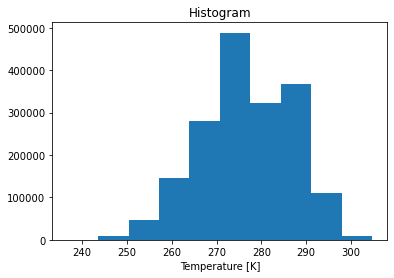

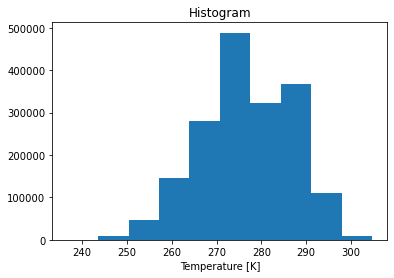

PermissionError: [Errno 13] Permission denied: b'/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0_intermediate.nc'

In [80]:
    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev= model_lev_i)
        dic_ds[key] = ds_l

  

      
    ds_t = dic_ds['IFS_T']
    
    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U','V','temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']),ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()
    

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()
    

In [23]:
fn_intermediate_ec_earth#.exists()

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0_intermediate.nc')

In [24]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)


/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


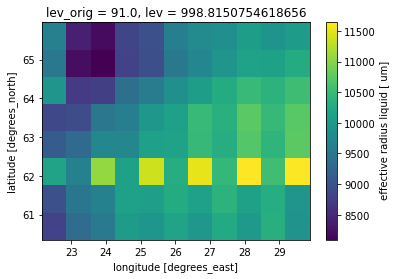

In [25]:
ds_ifs['re_liq_cltop'].count('time').plot()

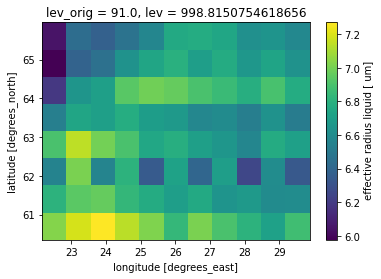

In [26]:
ds_ifs['re_liq_cltop'].mean('time').plot()

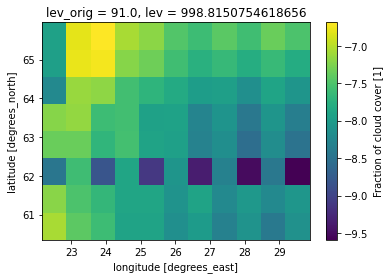

In [27]:
ds_ifs['argmax'].mean('time').plot()

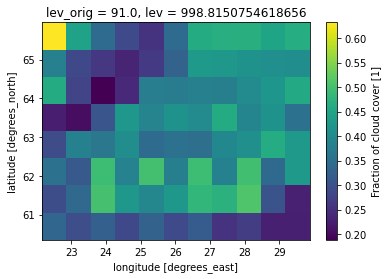

In [28]:
ds_ifs['cl_frac_where_cltime_pos'].mean('time').plot()

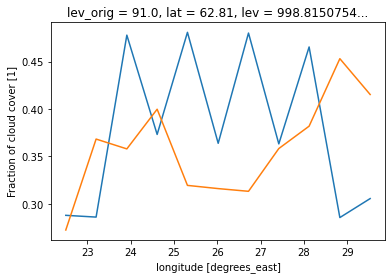

In [29]:
ds_ifs['cc'].where(ds_ifs['cc']>0).isel(lat=2).mean('time').plot()
ds_ifs['cc'].where(ds_ifs['cc']>0).isel(lat=3).mean('time').plot()

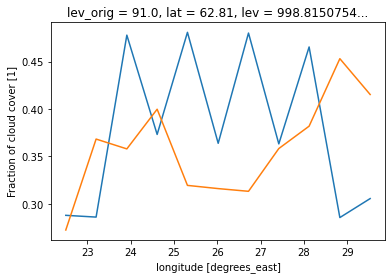

In [30]:
ds_ifs['cc'].where(ds_ifs['cc']>0).isel(lat=2).mean('time').plot()
ds_ifs['cc'].where(ds_ifs['cc']>0).isel(lat=3).mean('time').plot()

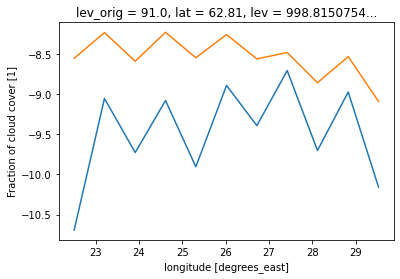

In [31]:
ds_ifs['argmax'].where(ds_ifs['cc']>0).isel(lat=2).mean('time').plot()
ds_ifs['argmax'].where(ds_ifs['cc']>0).isel(lat=3).mean('time').plot()

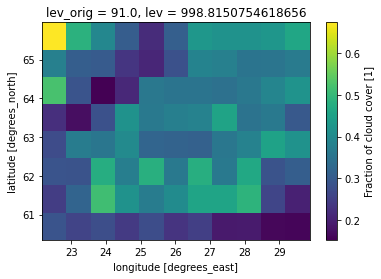

In [32]:
ds_ifs['cc_all'].mean('time').plot()

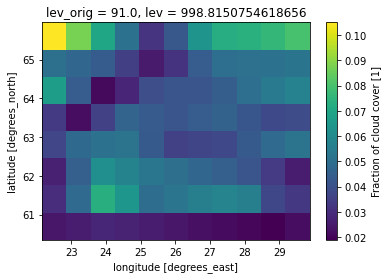

In [33]:
ds_ifs['cc'].mean('time').plot()

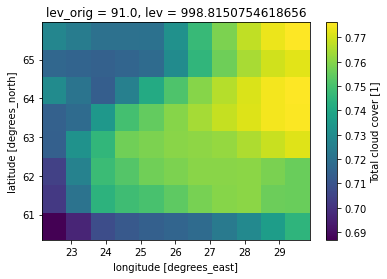

In [34]:
ds_ifs['ttc'].mean('time').plot()

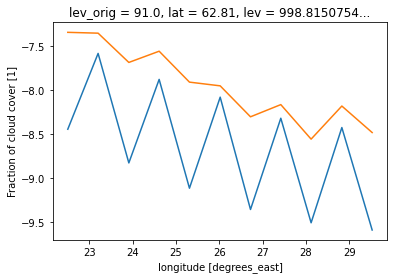

In [35]:
ds_ifs['argmax'].isel(lat=2).mean('time').plot()

ds_ifs['argmax'].isel(lat=3).mean('time').plot()

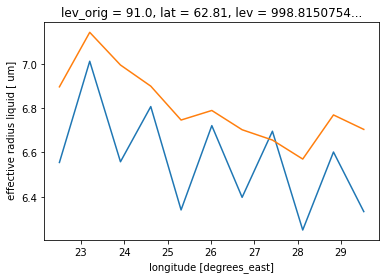

In [36]:
ds_ifs['re_liq_cltop'].isel(lat=2).mean('time').plot()

ds_ifs['re_liq_cltop'].isel(lat=3).mean('time').plot()

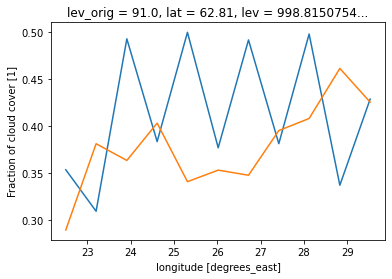

In [37]:
ds_ifs['cl_frac_where_cltime_pos'].isel(lat=2).mean('time').plot()

ds_ifs['cl_frac_where_cltime_pos'].isel(lat=3).mean('time').plot()

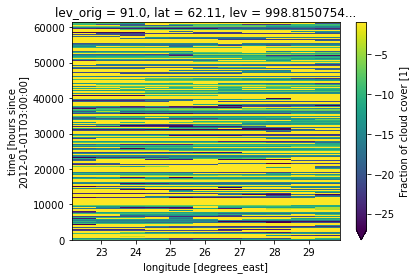

In [38]:
ds_ifs['argmax'].isel(lat=2,).plot(robust=True )#linewidth=0, marker='.')

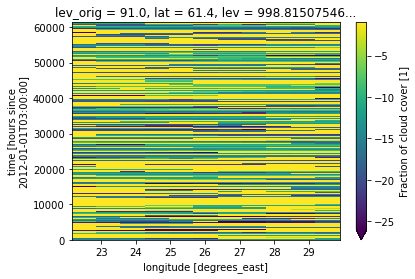

In [39]:
ds_ifs['argmax'].isel(lat=1,).plot( robust=True)#linewidth=0, marker='.')

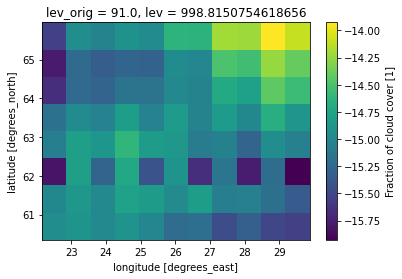

In [40]:
ds_ifs['argmax'].where(ds_ifs['argmax']<-1).mean('time').plot()

In [41]:
(ds_ifs['argmax']
 .where(ds_ifs['argmax']<-1)
 .isel(lat=2,lon=0).plot(x='time', linewidth=0, marker='.')

SyntaxError: unexpected EOF while parsing (349681506.py, line 3)

In [ ]:
ds_ifs['re_liq'].isel(lat=2,lon=0).plot(x='time', linewidth=0, marker='.')

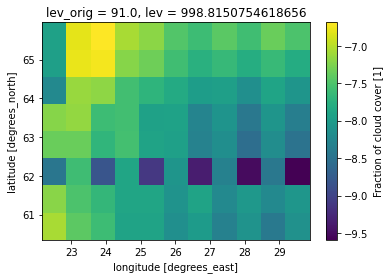

In [42]:
ds_ifs['argmax'].mean('time').plot()

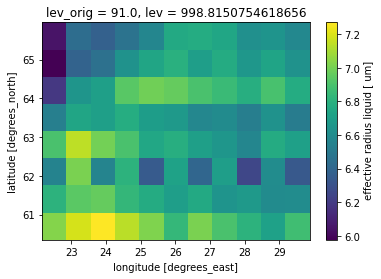

In [43]:
ds_ifs['re_liq_cltop'].mean('time').plot()

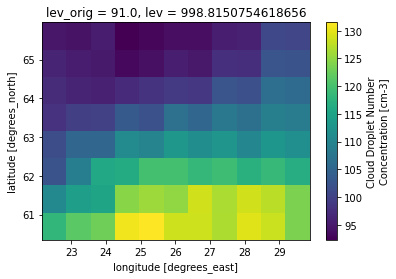

In [44]:
ds_ifs['cdnc_incld_cltop'].mean('time').plot()

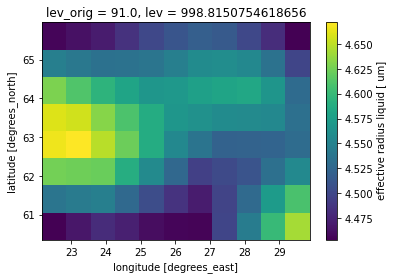

In [45]:
ds_ifs['re_liq'].mean('time').plot()

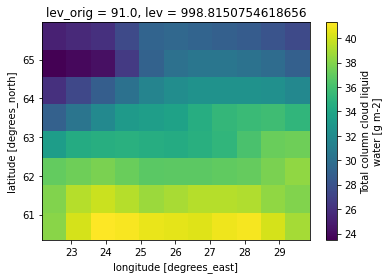

In [46]:
ds_ifs['tclw'].mean('time').plot()

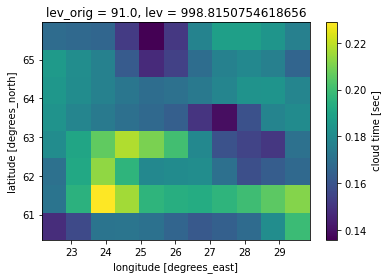

In [47]:
ds_ifs['cloud_time_norm'].mean('time').plot()

In [48]:
ds_ifs['ttc'].attrs['units'] =1

In [49]:
import numpy as np

## Fix wrong units:

In [50]:
for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units']==1:
            ds_ifs[v].attrs['units'] ='1'
            print(f'{v} unit is 1')

hyai Pa
hyam Pa
hybi 1
hybm 1
tcw g m-2
tcwv g m-2
ttc 1
ttc unit is 1
surf_net_srad J m-2
surf_net_lrad J m-2
toa_net_srad J m-2
toa_net_lrad J m-2
cdnc cm-3
toa_net_srad_clear J m-2
re_liq  um
surf_net_srad_clear J m-2
sur_net_lrad_clear J m-2
liq_cloud_time sec
cc 1
toa_net_srad_clearclean J m-2
toa_net_srad_clean J m-2
surf_net_srad_clearclean J m-2
surf_net_srad_clean J m-2
toa_net_lrad_clearclean J m-2
toa_net_lrad_clean J m-2
surf_net_lrad_clearclean J m-2
surf_net_lrad_clean J m-2
tclw g m-2
tciw g m-2
re_liq_incld  um
cdnc_incld cm-3
cl_time_liq_norm sec
cc_all 1
liq_frac_cwp g m-2
cl_frac_where_cltime_pos 1
cwp_incld g m-2
cloud_time_norm sec
cumsum 1
argmax 1
cdnc_incld_cltop cm-3
re_liq_cltop  um
cc_cltop 1
temp K


In [51]:
ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

In [52]:
import numpy as np

(array([101083.,  17641.,  11899.,  11459.,  14509.,  12769.,   6641.,
          7790.,  10037.,  35556.]),
 array([0.0078125 , 0.10703125, 0.20625   , 0.30546874, 0.4046875 ,
        0.50390625, 0.603125  , 0.70234376, 0.8015625 , 0.9007813 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

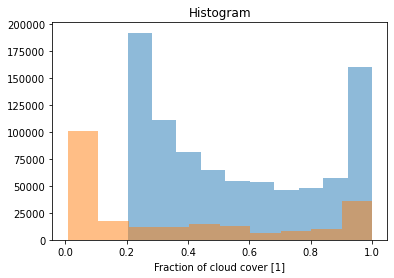

In [53]:
ds_ifs['cc_cltop'].plot(alpha=.5)

ds_ifs['cc_all'].plot(alpha=.5)

## Mask values where cloud fraction is less than 10 percent

In [54]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop']>.1)

## Take only values where liquid cloud fraction is above 80%

In [55]:
ds_ifs = ds_ifs.where( ds_ifs['liq_frac_cwp']>.8)

In [56]:
ds_ifs['tcw']

<xarray.DataArray 'tcw' (time: 20198, lat: 8, lon: 11)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,  3677.3958,
          3528.9583,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [ 4688.98  ,  4501.48  ,  4312.027 , ...,        nan,
                nan,  3458.5112],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [11956.51  , 11979.947 , 12003.385 , ...,        nan,
                nan,        nan],
        [       nan,        nan, 12026.822 , ...,        nan,
                nan,        nan],
        [       nan,        nan, 11843.229 , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    lev_orig  float64 91.0
  * lat       (lat) float64 60.7 61.4 62.11 62.81 63.51 64.21 64.91 65.61
  * lon       (lon) float64 22.5 23.2 23.91 24.61 ... 27.42 28.12 28.83 29.53
  * time      (time) datetime64[ns] 2012-01-01T03:00:00 ... 2019-01-01
    lev       float64 998.8
Attributes:
    table:      128
    long_name:  Total column water
    units:      g m-2

## Shift timezone

In [57]:
from datetime import timedelta
with ProgressBar():
    ds_ifs.load()
    
    
if ds_ifs['time'].attrs['timezone']=='utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index + timedelta(hours=2)
    ds_ifs['time'].attrs['timezone'] = 'utc+2'
    print('shifted time by +2')
    #dic_ds[k] = _ds

shifted time by +2


### Use station data computed before:

In [58]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [59]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station=ds_comb_station.assign_coords(station=[select_station])

(array([1.8000e+01, 1.3100e+02, 5.2300e+02, 3.5280e+03, 3.5635e+04,
        8.7338e+04, 7.4046e+04, 8.2129e+04, 2.2174e+04, 1.3760e+03]),
 array([241.66414, 247.96475, 254.26535, 260.56598, 266.86658, 273.16718,
        279.4678 , 285.7684 , 292.069  , 298.36963, 304.67023],
       dtype=float32),
 <BarContainer object of 10 artists>)

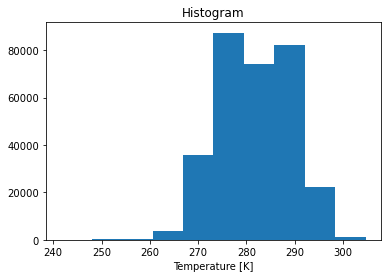

In [60]:
ds_ifs['temp'].plot()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


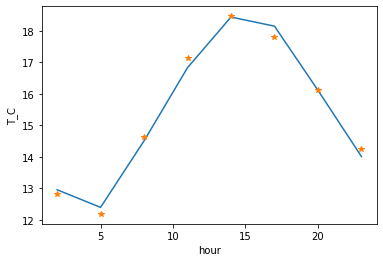

In [61]:
ds_ifs['hour'] = ds_ifs['time.hour']
_ds1 = ds_ifs.sel(time=slice('2012-07','2012-08'))
_ds2 = ds_comb_station.sel(time=slice('2012-07','2012-08'))
(_ds1['temp']-273.15).groupby(_ds1['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
_ds2['T_C'].groupby(_ds2['time.hour']).mean().plot(marker='*')

In [62]:
varl_station_ec_earth = [
 'CCN0.20',
 'CCN1.00',
 'M_BCACS',
 'M_BCAII',
 'M_BCAIS',
 'M_BCCOS',
 'M_DUACI',
 'M_DUACS',
 'M_DUCOI',
 'M_DUCOS',
 'M_POMACS',
 'M_POMAII',
 'M_POMAIS',
 'M_POMCOS',
 'M_SO4ACS',
 'M_SO4COS',
 'M_SO4NUS',
 'M_SOAACS',
 'M_SOAAII',
 'M_SOAAIS',
 'M_SOACOS',
 'M_SOANUS',
 'M_SSACS',
 'M_SSCOS',
    'OA',
    'SOA',
 'N_ACI',
 'N_ACS',
 'N_AII',
 'N_AIS',
 'N_COI',
 'N_COS',
 'N_NUS',
 'RDRY_ACS',
 'RDRY_AIS',
 'RDRY_COS',
 'RDRY_NUS',
 'RWET_ACI',
 'RWET_ACS',
 'RWET_AII',
 'RWET_AIS',
 'RWET_COI',
 'RWET_COS',
 'RWET_NUS',
 'emiisop',
 'emiterp',
 'T',
 'DDRY_NUS',
 'DDRY_AIS',
 'DDRY_ACS',
 'DDRY_COS',
 'DWET_AII',
 'DWET_ACI',
 'DWET_COI',
 'N50',
 'N70',
 'N100',
 'N150',
 'N200',
 'N500',
 'N50-500',
 'N70-500',
 'N100-500',
 'N150-500',
 'N200-500',
 'OA',
 'POM',
 'SOA',
 'SOA2',
 'T_C',
    
]

In [63]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth)))

In [64]:
ds_smll = ds_ifs[['temp']]

In [65]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud

In [66]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds= False)

RWET_NUS
RDRY_ACS
N150
N_AII
M_SOACOS
N100-500
RWET_ACS
M_SOANUS
SOA
N_ACI
DDRY_COS
N70-500
DWET_AII
T_C
M_SSCOS
M_BCACS
M_DUCOS
RWET_COI
N_NUS
M_DUACS
N200
M_SOAACS
N100
M_SSACS
N_COI
DWET_COI
emiterp
DDRY_AIS
RWET_AIS
T
DDRY_ACS
N50
N500
N200-500
OA
N_ACS
N70
M_BCAII
M_POMCOS
M_POMAII
M_DUCOI
N_AIS
M_POMACS
M_DUACI
RWET_COS
RDRY_AIS
RDRY_COS
N150-500
M_BCAIS
SOA2
M_SO4ACS
M_SO4COS
CCN1.00
RWET_ACI
emiisop
M_POMAIS
M_BCCOS
POM
M_SO4NUS
M_SOAAII
RWET_AII
CCN0.20
M_SOAAIS
DDRY_NUS
DWET_ACI
N_COS
N50-500
RDRY_NUS


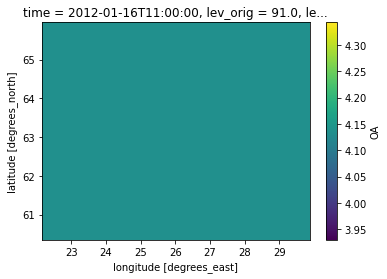

In [72]:
ds_smll['OA'].isel(time=122).plot()

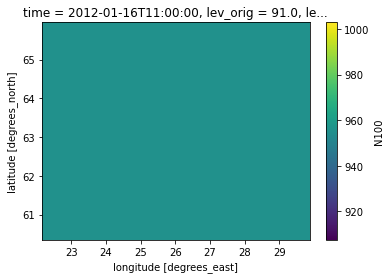

In [73]:
ds_smll['N100'].isel(time=122).plot()

## Replace all values by station values

In [74]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

### Mask values where ice water path larger than 20 percent

(array([20824., 21949., 22952., 23690., 24551., 24900., 25217., 26307.,
        29079., 87429.]),
 array([0.8000218 , 0.82001966, 0.84001744, 0.8600153 , 0.8800131 ,
        0.90001094, 0.9200087 , 0.94000655, 0.9600044 , 0.98000216,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

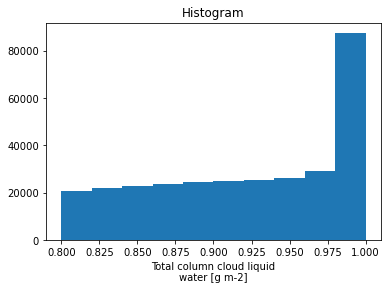

In [75]:
ds_ifs['liq_frac_cwp'].plot()

In [76]:
ds_ifs = ds_ifs.where(ds_ifs['liq_frac_cwp']>.8)

## Calculate in-cloud liquid water path:

In [77]:
#ds_ifs.rename({'CWP':'CWP_tot'})
ds_ifs['cwp_incld'] = ds_ifs['tclw']/ds_ifs['ttc']

In [98]:
_ds['tclw_incld'] = _ds['tclw']/_ds['ttc']

## Save for different seasons: 


In [78]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

In [79]:
#calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [80]:
ds = dic_ds[key]

(array([2.4560e+03, 2.1780e+04, 2.2127e+04, 2.9834e+04, 3.6247e+04,
        4.0114e+04, 3.9528e+04, 3.3354e+04, 2.4357e+04, 1.5954e+04,
        1.0955e+04, 7.4800e+03, 5.3360e+03, 3.8200e+03, 2.8700e+03,
        2.1600e+03, 1.6800e+03, 1.2220e+03, 9.7500e+02, 7.8400e+02,
        6.1900e+02, 5.2300e+02, 3.9100e+02, 3.6900e+02, 2.9200e+02,
        2.8900e+02, 2.6000e+02, 1.8600e+02, 1.7400e+02, 1.4400e+02,
        1.1400e+02, 7.2000e+01, 5.9000e+01, 2.8000e+01, 2.4000e+01,
        7.0000e+00, 1.1000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 3.        ,  3.75510204,  4.51020408,  5.26530612,  6.02040816,
         6.7755102 ,  7.53061224,  8.28571429,  9.04081633,  9.79591837,
        10.55102041, 11.30612245, 12.06122449, 12.81632653, 13.57142857,
        14.32653061, 15.08163265, 15.83673469, 16.59183673, 17.34693878,
        18.10204082, 18.85714286, 19.6

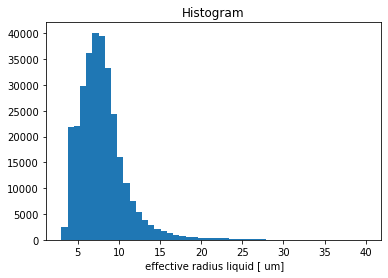

In [81]:
ds['r_eff'].plot(bins = np.linspace(3,40))

In [82]:
ds['CWP_unweigth'] = ds['tclw']

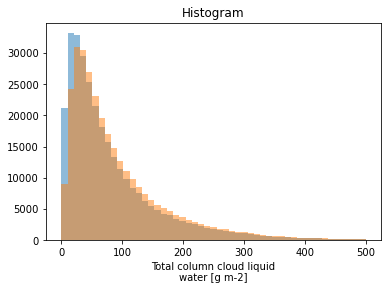

In [83]:
ds['CWP_unweigth'].plot(bins=np.linspace(0,500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0,500), alpha=.5);

## Check 

(array([1.53100e+04, 1.17111e+05, 1.27027e+05, 3.26880e+04, 8.98700e+03,
        3.18200e+03, 1.42100e+03, 8.21000e+02, 2.99000e+02, 5.20000e+01]),
 array([ 1.0606035,  4.106164 ,  7.151725 , 10.197286 , 13.2428465,
        16.288406 , 19.333967 , 22.379528 , 25.425089 , 28.47065  ,
        31.51621  ], dtype=float32),
 <BarContainer object of 10 artists>)

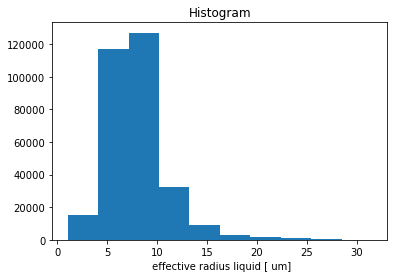

In [84]:
ds['r_eff'].plot()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'CWP divided by cloud fraction')

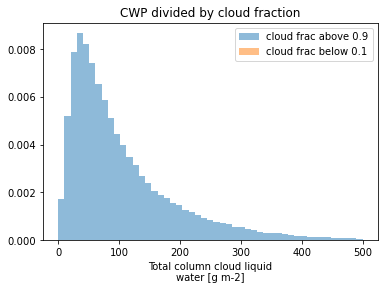

In [85]:
ds['CWP'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc']<.1).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP divided by cloud fraction')

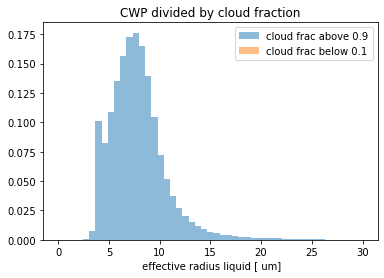

In [86]:
ds['r_eff'].where(ds['ttc']>.9).plot(bins=np.linspace(0,30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc']<.1).plot(bins=np.linspace(0,30), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

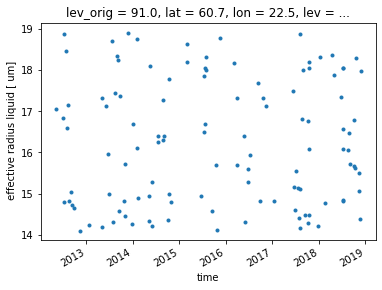

In [87]:
ds['r_eff'].where(ds['r_eff']>14).where(ds['r_eff']<19).isel(lat=0, lon = 0).plot(linewidth=0, marker='.')

In [88]:
ds['r_eff'].where((ds['r_eff']==16)).count()/ds['r_eff'].where(ds['r_eff']>0).count()

<xarray.DataArray 'r_eff' ()>
array(0.)
Coordinates:
    lev_orig  float64 91.0
    lev       float64 998.8
Attributes:
    table:      126
    long_name:   effective radius liquid
    units:       um

Text(0.5, 1.0, 'CWP divided by cloud fraction')

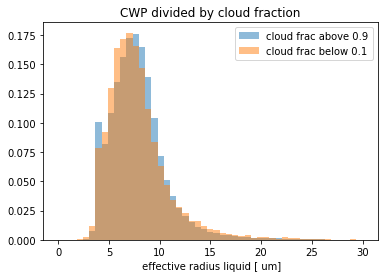

In [89]:
ds['r_eff'].where(ds['ttc']>.9).plot(bins=np.linspace(0,30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc']<.4).plot(bins=np.linspace(0,30), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'CWP not divided ')

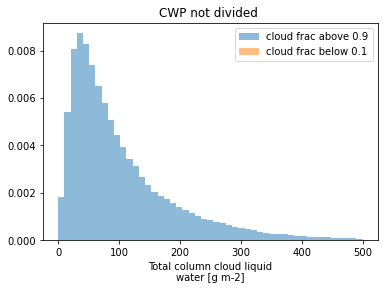

In [90]:
ds['CWP_unweigth'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc']<.1).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP not divided ')

In [91]:
_ds = ds.copy()
_ds['month'] = _ds['time.month']
_ds = _ds.where(_ds['month'].isin([7,8]))

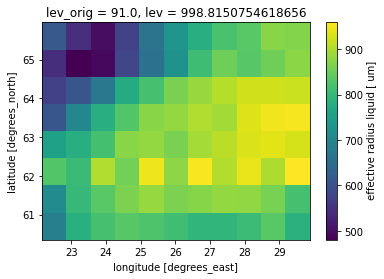

In [99]:
_ds['r_eff'].count('time').plot()

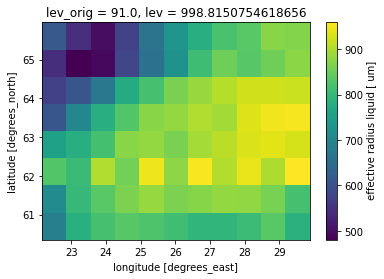

In [100]:
ma_liqfrac = _ds['liq_frac_cwp']>.8
_ds['r_eff'].where(ma_liqfrac).count('time').plot()

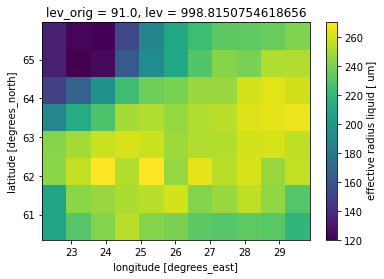

In [101]:
min_cwp = 50
ma_cwp = _ds['tclw_incld']>min_cwp
_ds['r_eff'].where(ma_liqfrac& ma_cwp).resample(time='D').mean().count('time').plot()

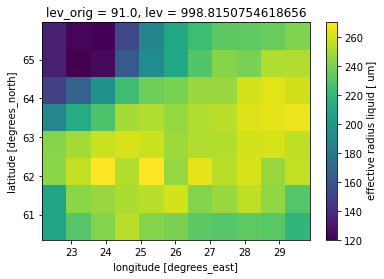

In [102]:
min_cwp = 50
ma_r_eff = _ds['r_eff']>1
_ds['r_eff'].where((ma_liqfrac& ma_cwp)&ma_r_eff).resample(time='D').mean().count('time').plot()

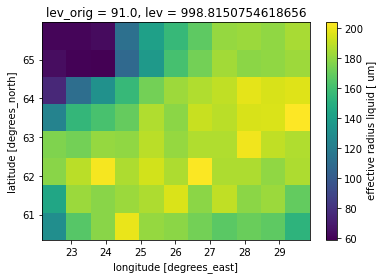

In [103]:
_ds['hour'] = _ds['time.hour']
hours_we_want = (_ds['hour'] >= daytime_from) & (_ds['hour'] <= daytime_to)
_ds['r_eff'].where((ma_liqfrac& ma_cwp)&(ma_r_eff&hours_we_want)).resample(time='D').median().count('time').plot()

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv


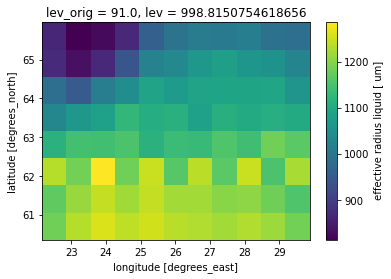

hours


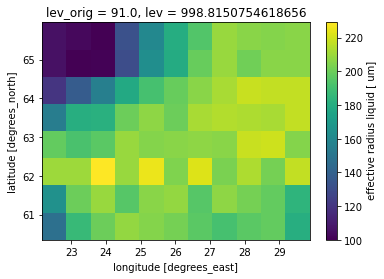

{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP!
Masking with r_eff>1!
cloud and resampled


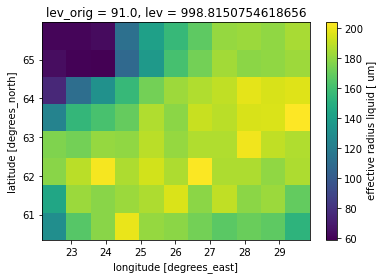

cloud_avg median


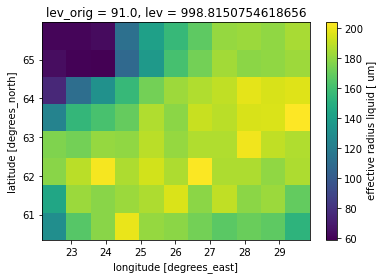

station


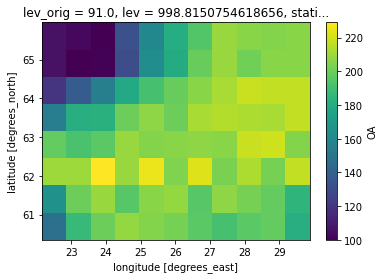

merge


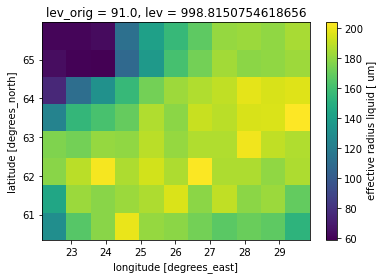

df1


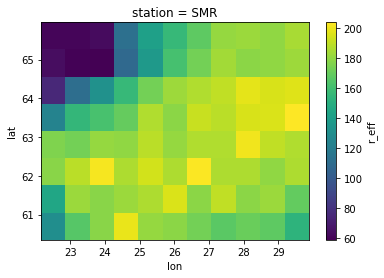

In [104]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas+'.csv')
    print(_fn_csv)
    

    if True:#not _fn_csv.exists():
        #for key in dic_ds.keys():
    
        dic_df = get_dic_df_mod(dic_ds, 
                                select_hours_clouds=True, 
                                summer_months=season2month[seas],
                                mask_cloud_values =True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                #kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds = dict(min_reff=r_eff_lim,
                                                         min_cwp =cld_water_path_above, 
                                                         tau_bounds = tau_lims
                                                        ),
                                
                               
                               )

        df_mod = dic_df[case_name_ec_earth]
        #with ProgressBar():
        #df_mod = df_mod.dropna()    
        df_mod.to_csv(_fn_csv)

In [105]:
dic_df.keys()

dict_keys(['ECE3_output_Sara'])

last before return


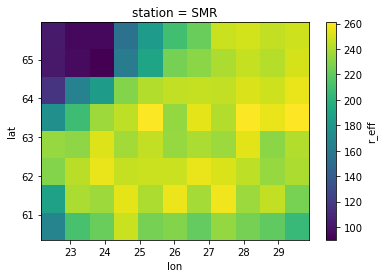

In [160]:
    df = dic_df['ECE3_output_Sara']
    print('last before return')
    #_df = df.dropna()
    _dds = df.to_xarray()
    (_dds['r_eff']
         .where(_dds['time.month'].isin([7,8]))
         .count('time').plot()
    )
    
    plt.show()

In [216]:
    df = dic_df['ECE3_output_Sara']
    print('last before return')
    #_df = df.dropna()
    _dds = df.to_xarray()
    

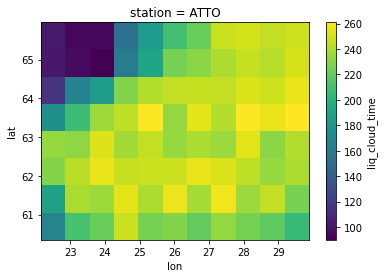

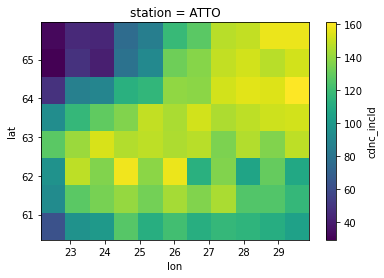

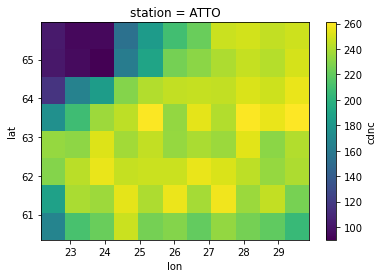

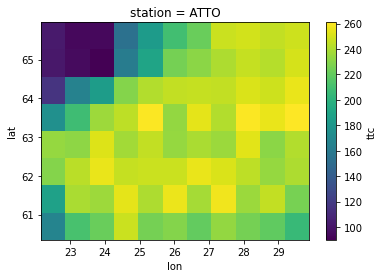

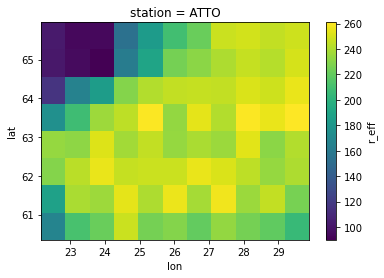

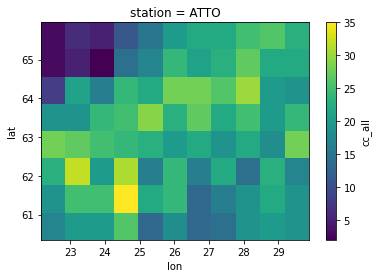

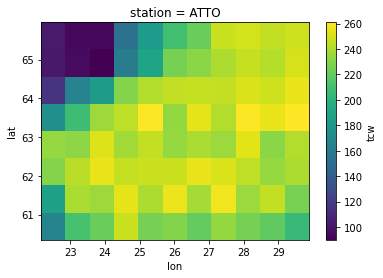

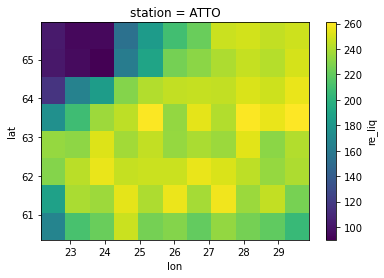

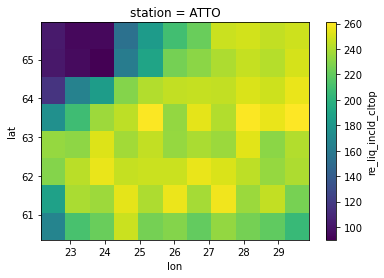

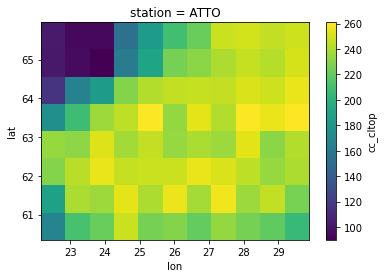

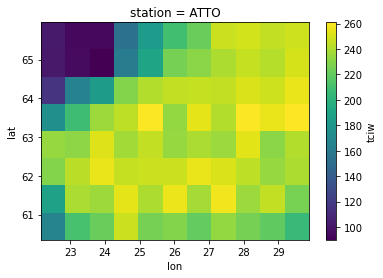

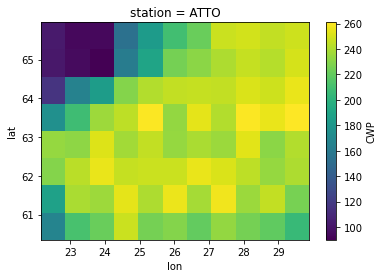

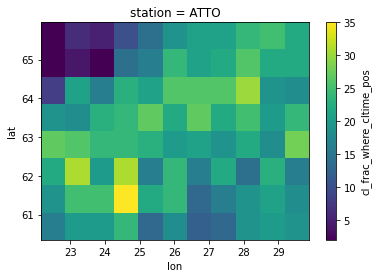

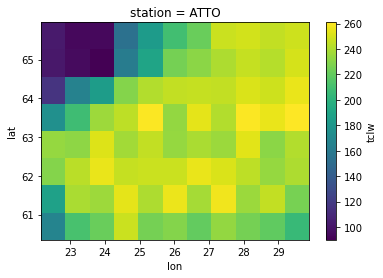

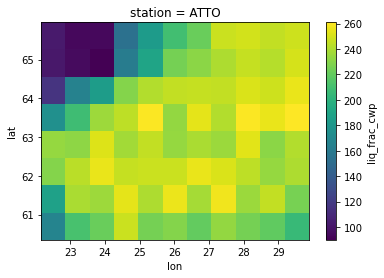

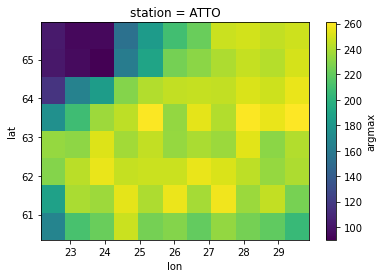

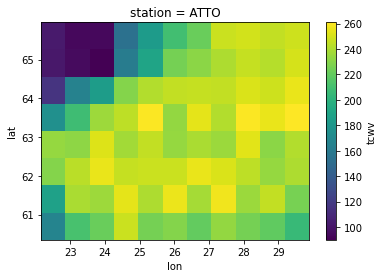

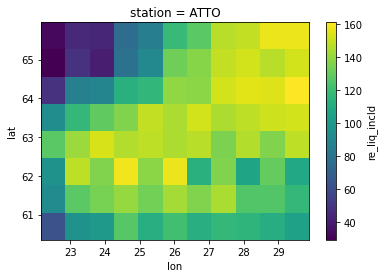

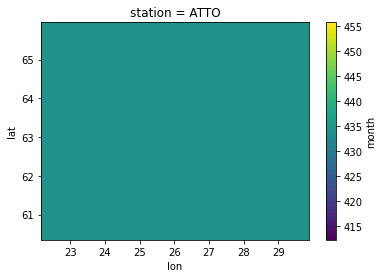

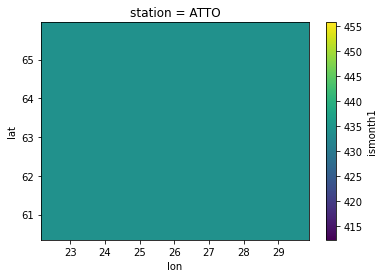

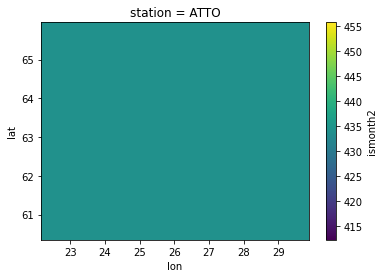

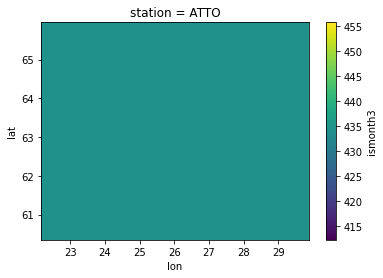

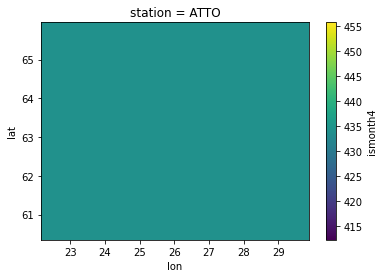

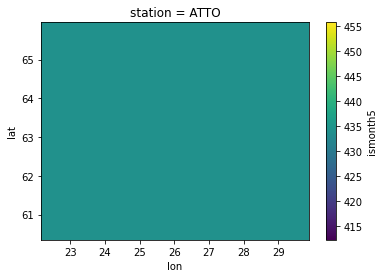

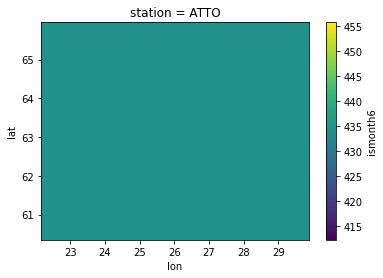

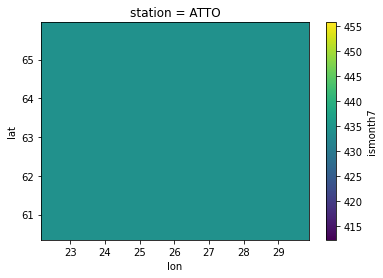

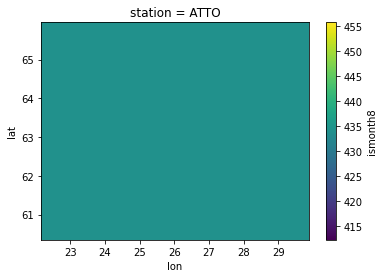

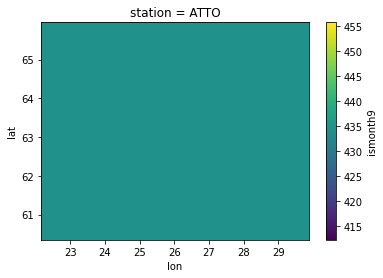

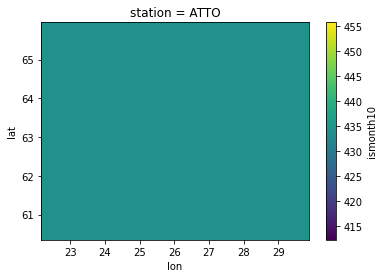

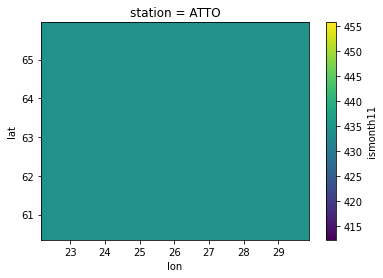

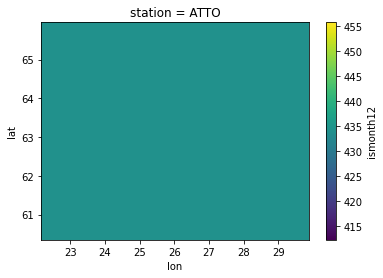

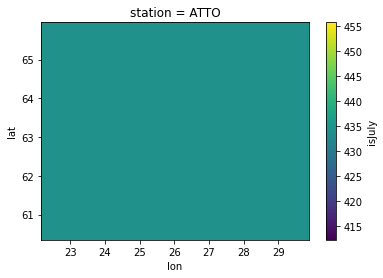

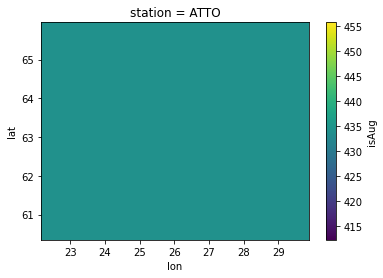

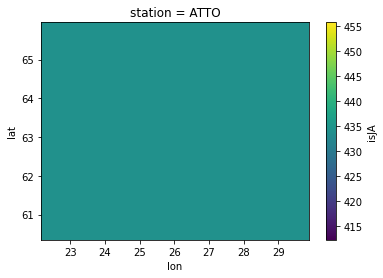

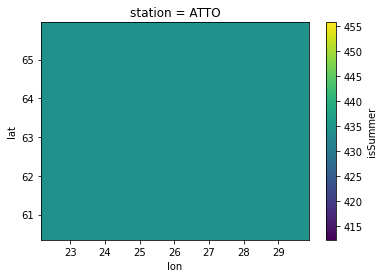

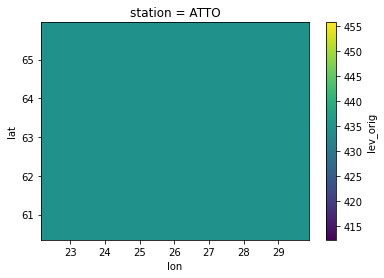

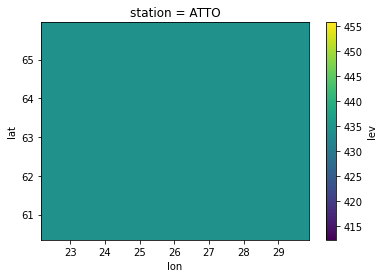

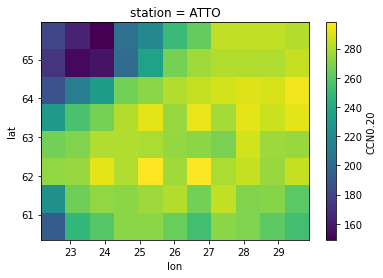

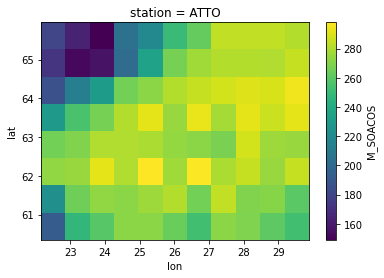

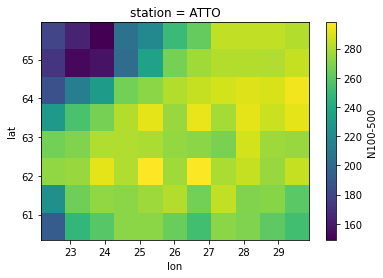

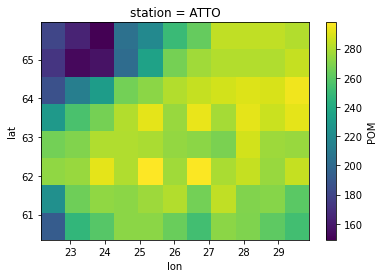

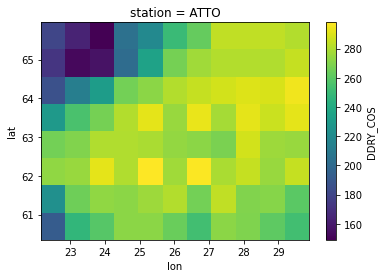

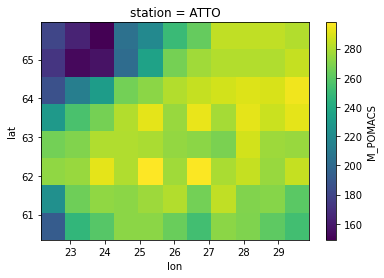

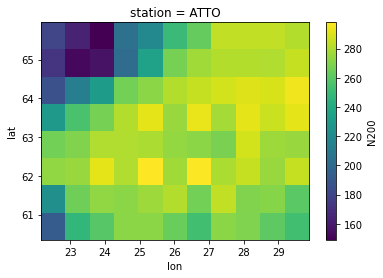

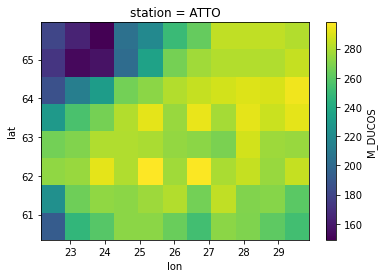

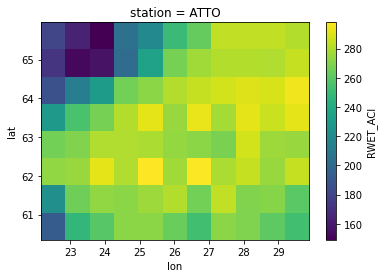

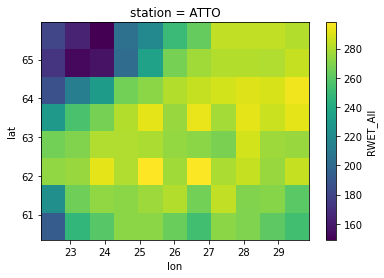

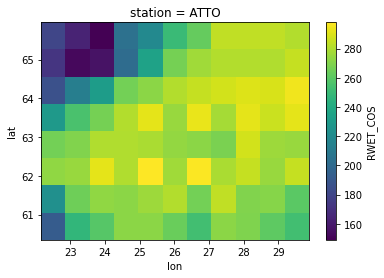

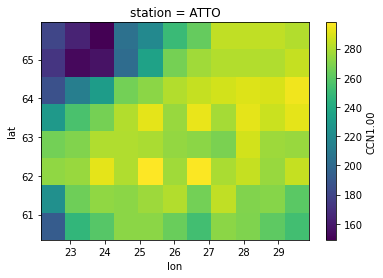

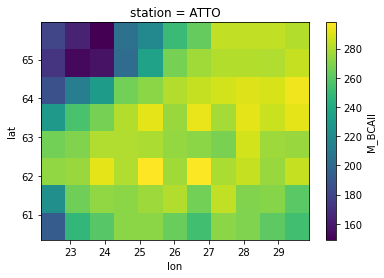

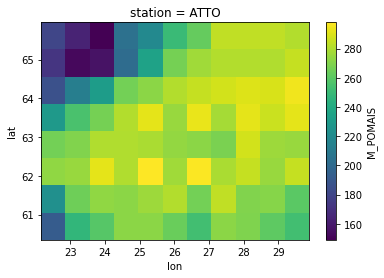

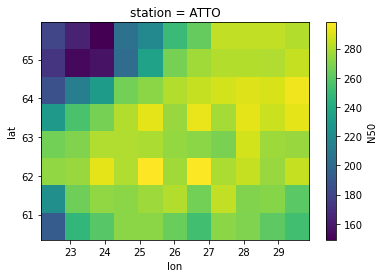

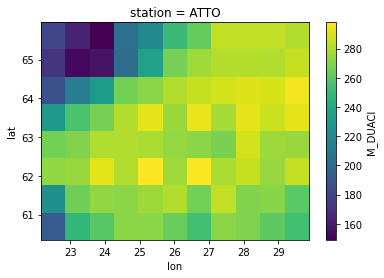

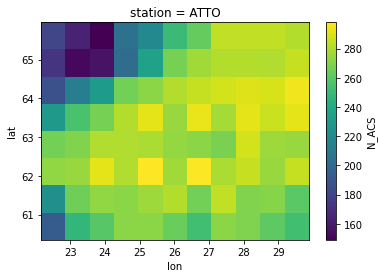

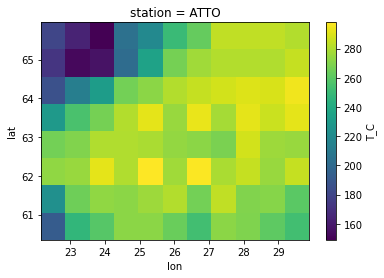

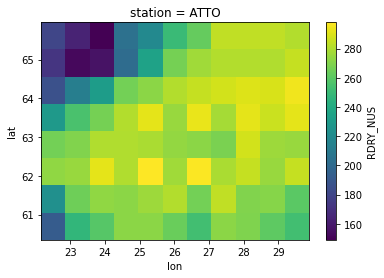

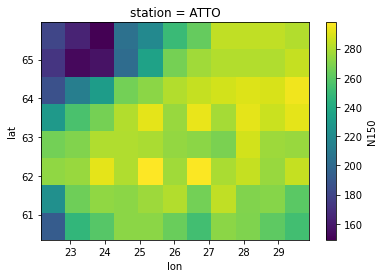

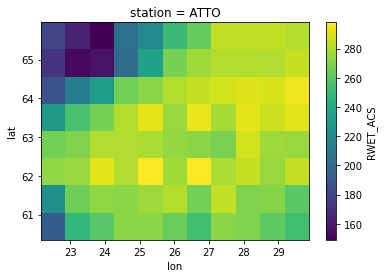

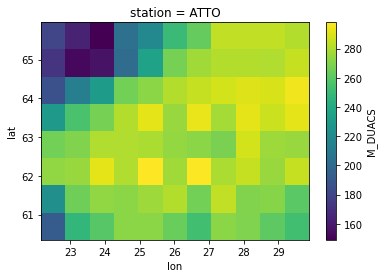

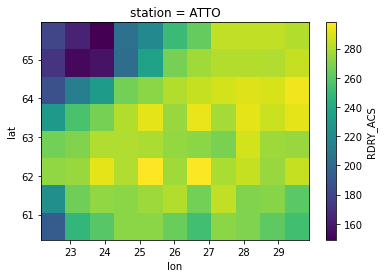

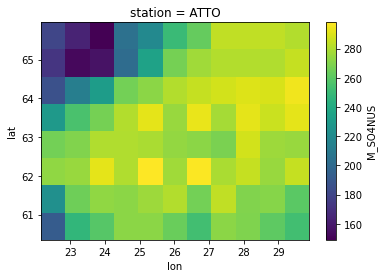

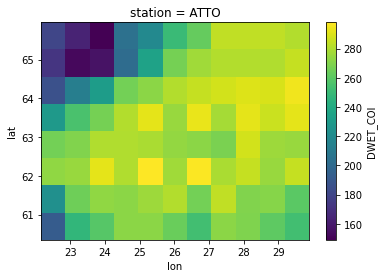

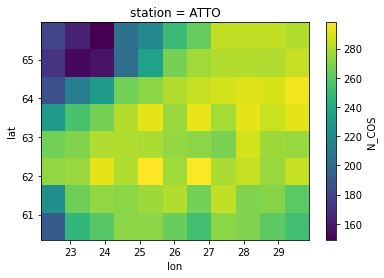

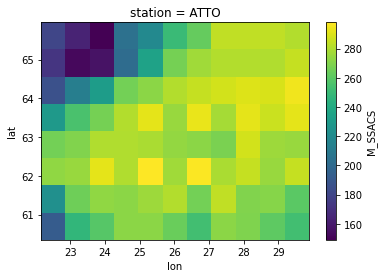

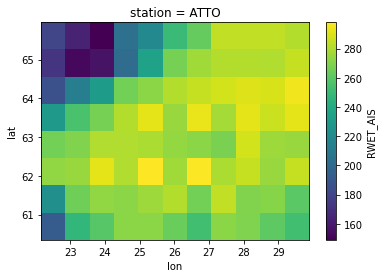

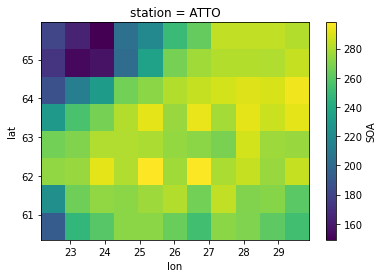

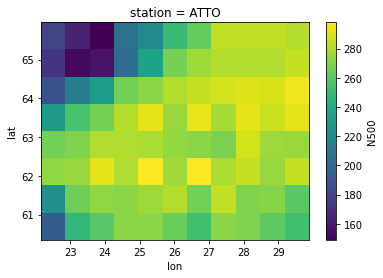

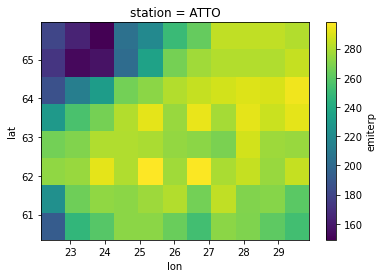

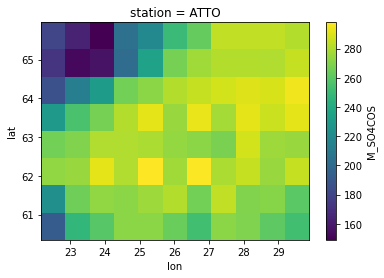

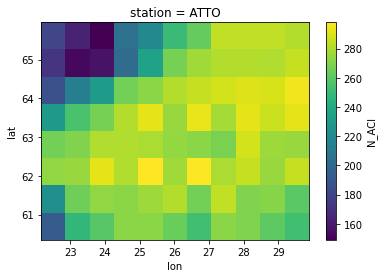

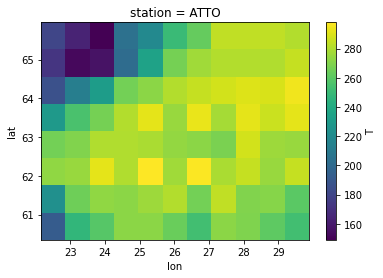

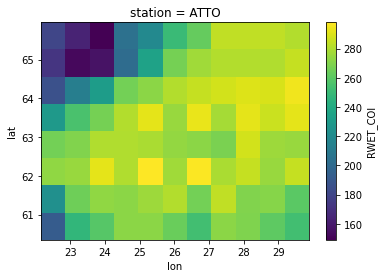

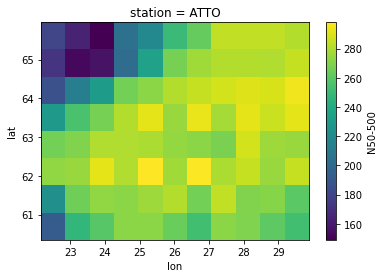

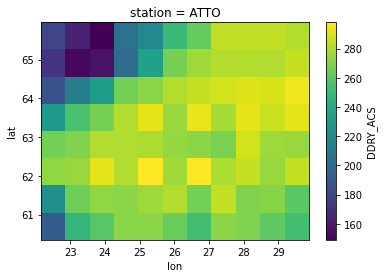

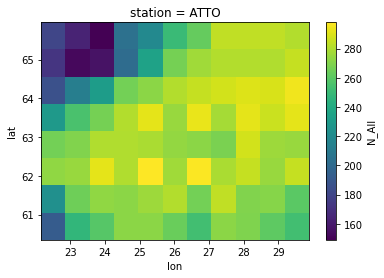

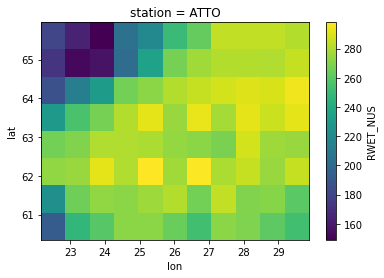

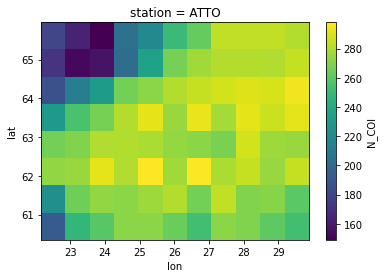

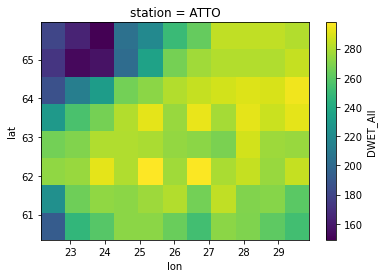

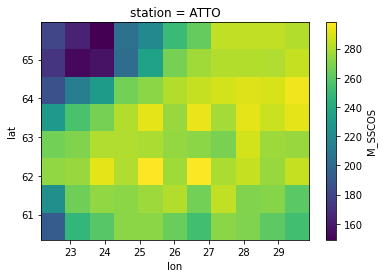

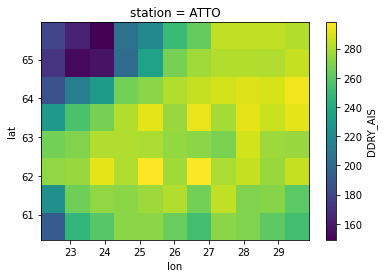

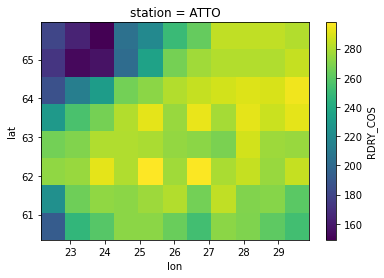

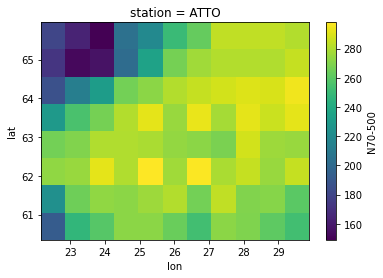

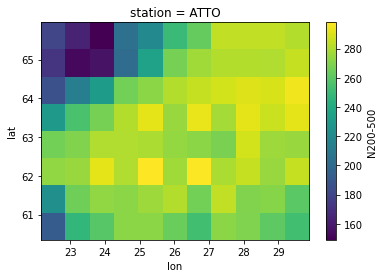

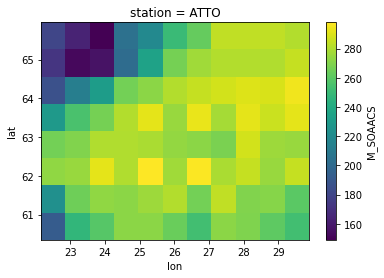

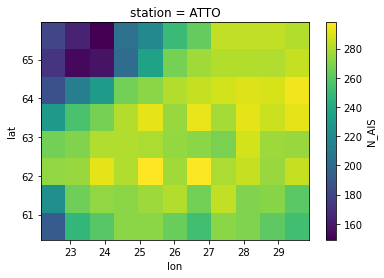

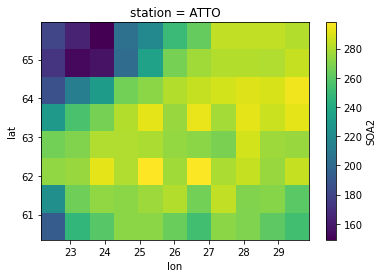

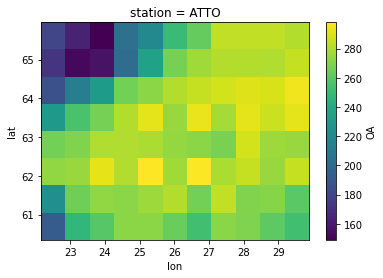

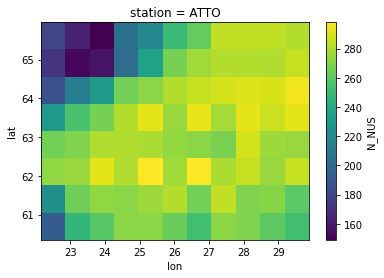

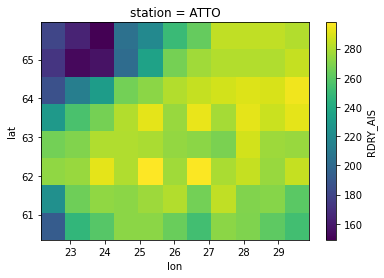

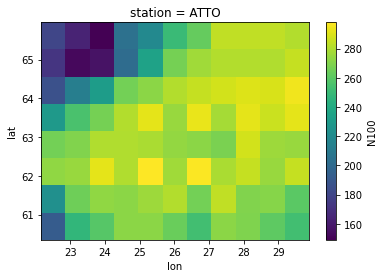

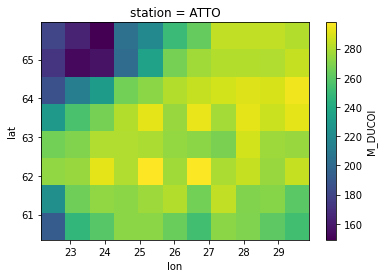

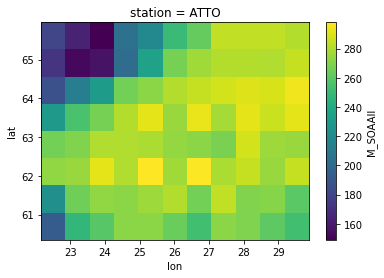

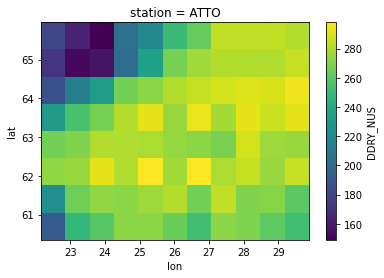

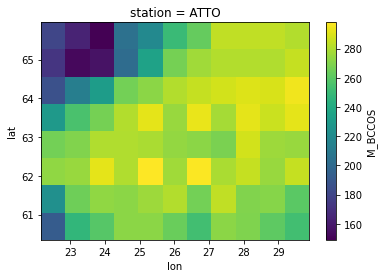

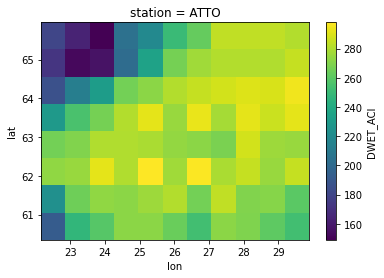

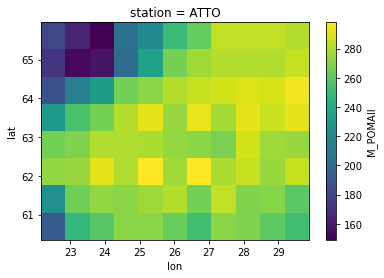

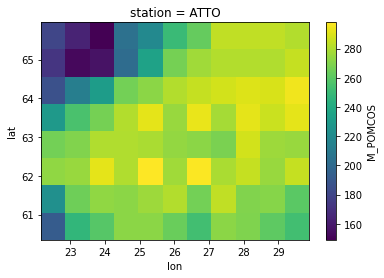

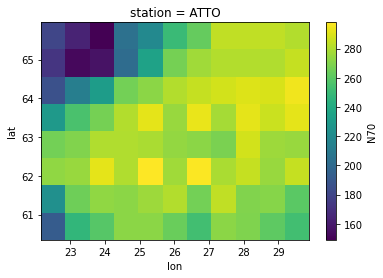

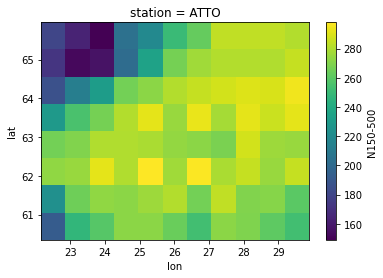

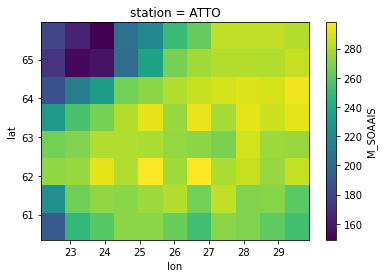

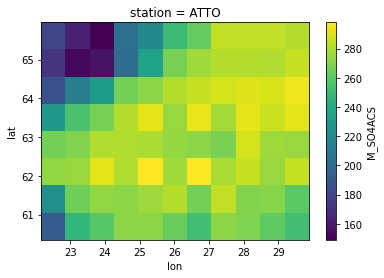

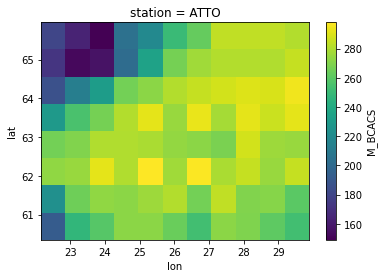

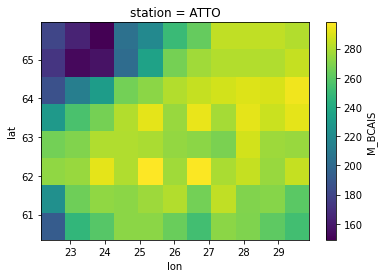

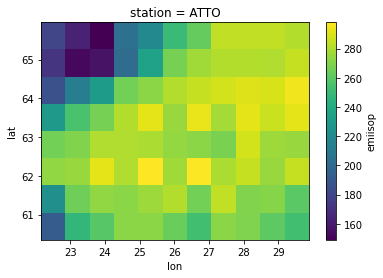

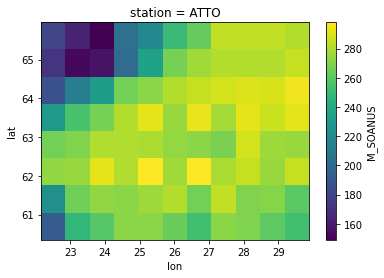

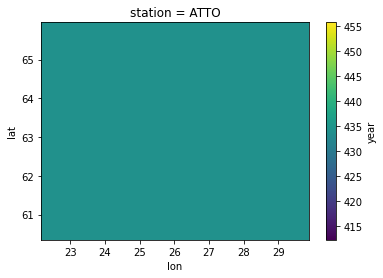

In [217]:
for v in _dds.data_vars:
    (_dds[v]
         .where(_dds['time.month'].isin([7,8]))
         .count('time').plot()
    )
    
    plt.show()

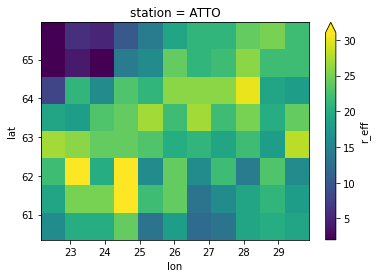

In [210]:
_dsss = df_mod.to_xarray()
(_dsss['r_eff']
 .where(_dsss['time.month'].isin([7,8]))
 .count('time').plot(robust=True)
       )

In [73]:
_fn_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv')

In [67]:
df = pd.read_csv(_fn_csv, index_col=[0,1,2])

<AxesSubplot:ylabel='Frequency'>

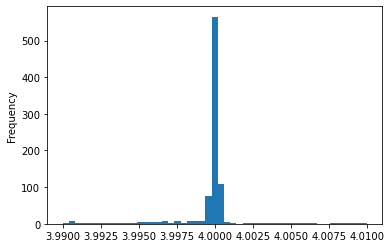

In [75]:
df['r_eff'].plot.hist(bins=np.linspace(3.99,4.01))

In [69]:
_dsf = df.to_xarray()

In [72]:
_dsf['time'] = pd.to_datetime(_dsf['time'] )

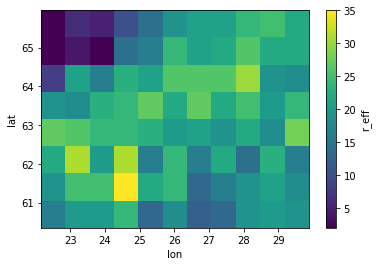

In [73]:
(_dsf
 .where(_dsf['time.month'].isin([7,8]))
 ['r_eff'].count('time')
 .plot()
)

<AxesSubplot:xlabel='time,lat,lon'>

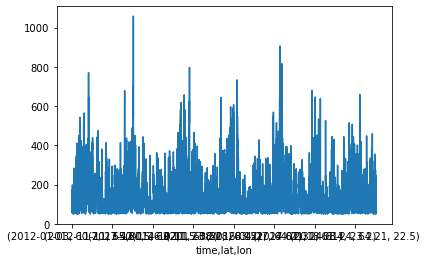

In [76]:
df['CWP'].plot()

In [77]:
df['ti_dt'] = pd.to_datetime(df.index.get_level_values(0).values)

In [78]:
df['month'] = df['ti_dt'].dt.month

<AxesSubplot:ylabel='Frequency'>

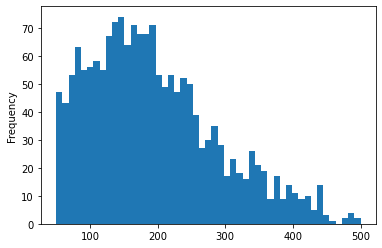

In [79]:
df[df['month'].isin([7,8])]['CWP'].plot.hist(bins = np.linspace(50,500))

<AxesSubplot:ylabel='Frequency'>

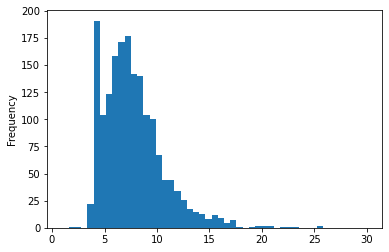

In [80]:
df[df['month'].isin([7,8])]['r_eff'].plot.hist(bins = np.linspace(1,30))

In [81]:
from datetime import timedelta